# Programmers Project 2 : Data Visualization Based on Python

### Team 4       
#### Group 1

##### 구성원 : 김강산, 김준석, 박지은, 조민서 

## Kaggle 데이터셋을 활용한 Python 데이터 분석 프로그래밍

## Dataset 소개 

### Fast Food Marketing Campaign A/B Test


**Scenario :**

A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks.

**Goal**

Evaluate A/B testing results and decide which marketing strategy works the best.

**Columns**

MarketID: unique identifier for market
MarketSize: size of market area by sales
LocationID: unique identifier for store location
AgeOfStore: age of store in years
Promotion: one of three promotions that were tested
week: one of four weeks when the promotions were run
SalesInThousands: sales amount for a specific LocationID, Promotion, and week


https://www.kaggle.com/datasets/chebotinaa/fast-food-marketing-campaign-ab-test

# Data

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import kruskal
import scipy.stats as stats
!pip install scikit-posthocs
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



  Obtaining dependency information for scikit-posthocs from https://files.pythonhosted.org/packages/43/bd/ca9d53c0e5abd1ef3c3717a4a9070e3ee339116b82c0c6cd28df51a921c6/scikit_posthocs-0.8.1-py3-none-any.whl.metadata
/kaggle/input/fast-food-marketing-campaign-ab-test/WA_Marketing-Campaign.csv


In [2]:
df=pd.read_csv('/kaggle/input/fast-food-marketing-campaign-ab-test/WA_Marketing-Campaign.csv')

In [3]:
df

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81
...,...,...,...,...,...,...,...
543,10,Large,919,2,1,4,64.34
544,10,Large,920,14,2,1,50.20
545,10,Large,920,14,2,2,45.75
546,10,Large,920,14,2,3,44.29


In [4]:
df.describe()

,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,3.000000,4.000000,99.650000


# EDA

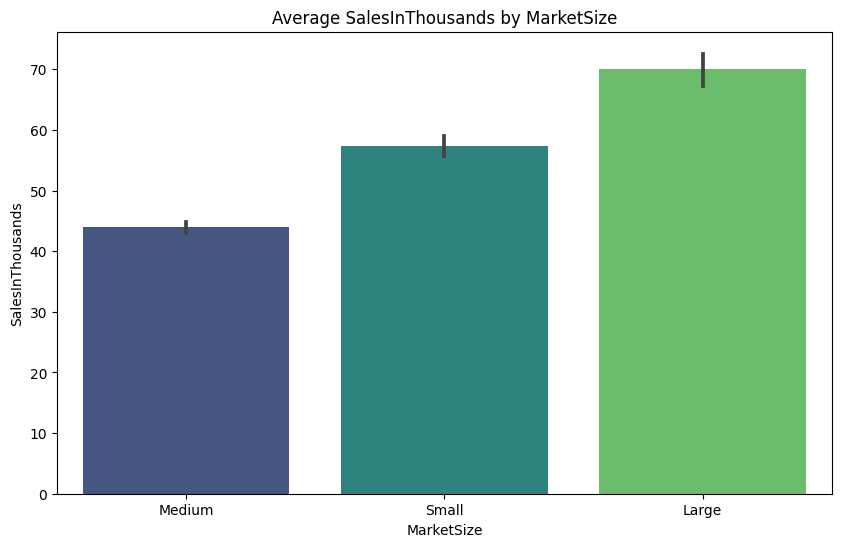

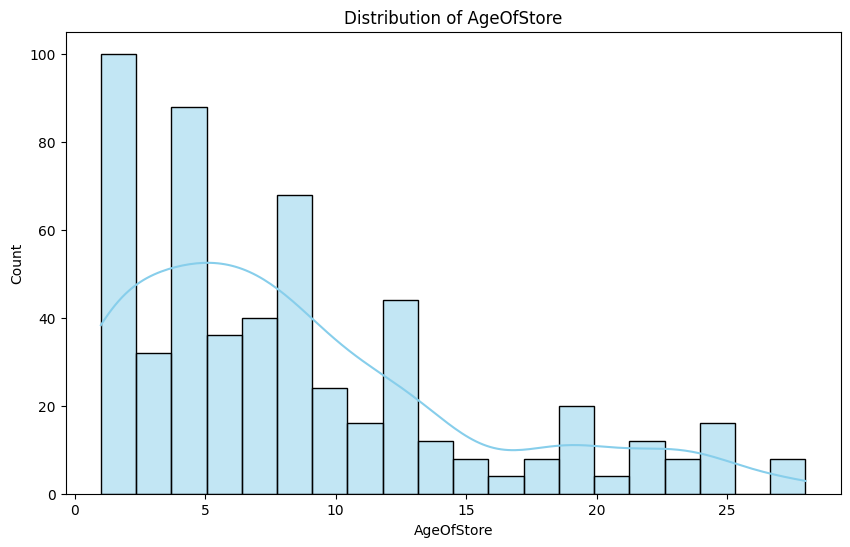

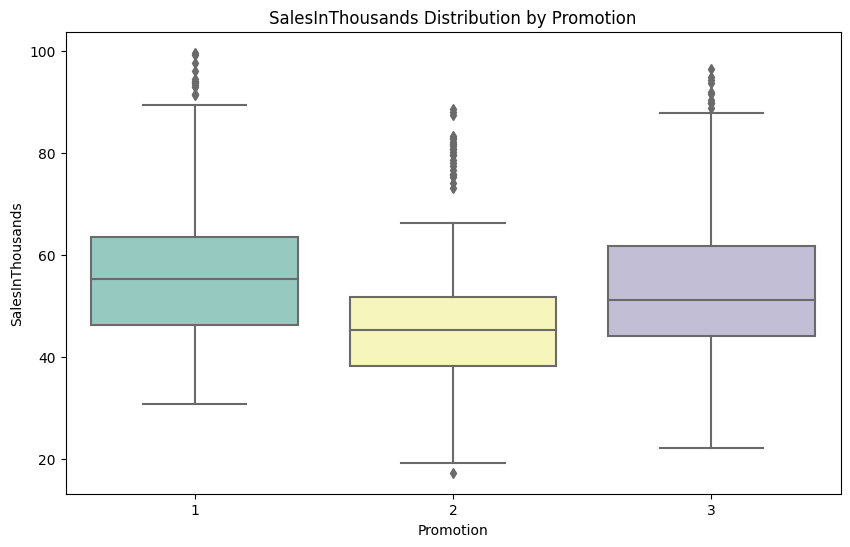

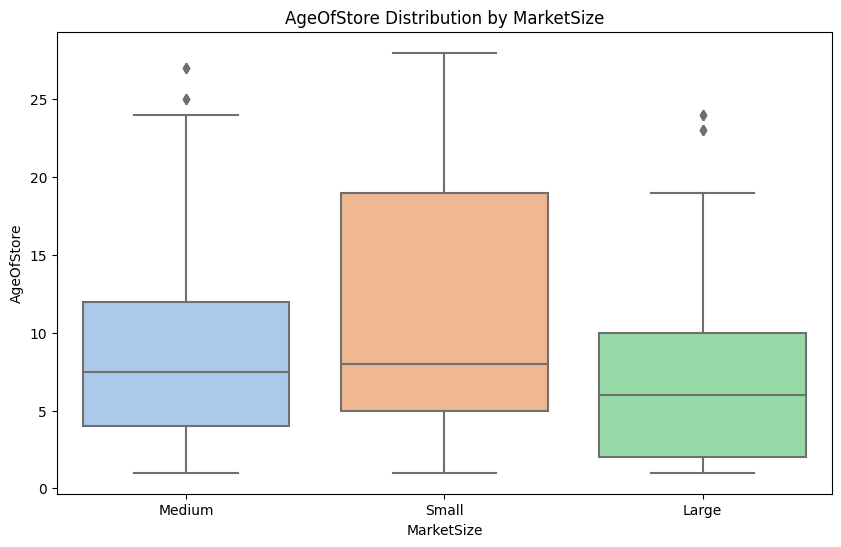

In [5]:
# MarketSize 별 SalesInThousands의 평균 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='MarketSize', y='SalesInThousands', data=df, palette='viridis')
plt.title('Average SalesInThousands by MarketSize')
plt.show()

# AgeOfStore 분포 확인
plt.figure(figsize=(10, 6))
sns.histplot(df['AgeOfStore'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of AgeOfStore')
plt.xlabel('AgeOfStore')
plt.show()

# Promotion에 따른 SalesInThousands 분포 확인
plt.figure(figsize=(10, 6))
sns.boxplot(x='Promotion', y='SalesInThousands', data=df, palette='Set3')
plt.title('SalesInThousands Distribution by Promotion')
plt.show()

# MarketSize에 따른 AgeOfStore의 상자 그림
plt.figure(figsize=(10, 6))
sns.boxplot(x='MarketSize', y='AgeOfStore', data=df, palette='pastel')
plt.title('AgeOfStore Distribution by MarketSize')
plt.show()

# Fast Food Marketing Campaign 주제별 A/B Test
- 프로모션 유형별 A/B Test
- 지역별 A/B Test
- 운영기간별 A/B Test
- 시장 크기별 A/B Test

# 프로모션 유형별 A/B Test

## 개요

### 프로모션의 종류
- 프로모션 1
- 프로모션 2
- 프로모션 3

### 2. 테스트 변수
- 주차(week) : 프로모션의 효과를 주차별로 추적하고 비교하기 위한 변수
- 매출액(SalesInThousands) : 주차별 매출액을 측정하는 주요 성과 지표

### 3. 목표값
- 매출액 증대 : 프로모션 A, B, C 중 어떤 프로모션이 더 매출을 증대시키는지 확인

## 가설 검정 


### 가설 1. 프로모션 별로 매출의 분포는 다를 것이다.

#### i. 정규성 검증

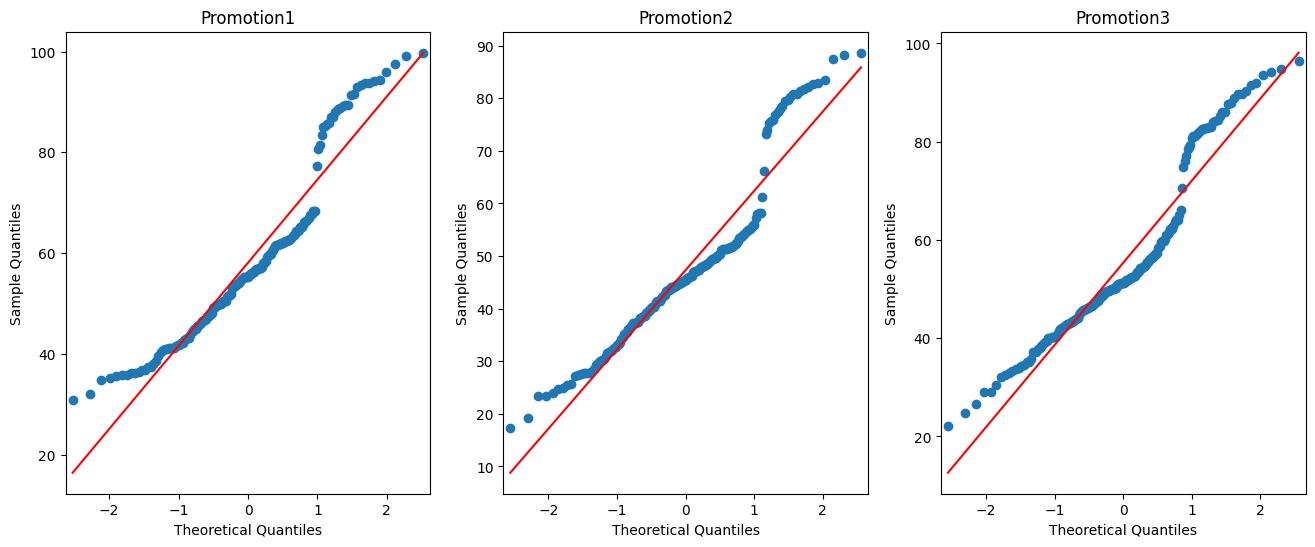

Shapiro-Wilk 검정 결과 (p-value)
Promotion1: 0.00000
Promotion2: 0.00000
Promotion3: 0.00000


In [6]:
def is_normal(df, xlabel, ylabel):
    f, ax = plt.subplots(1, 3, figsize=(16, 6))

    qqplot(np.array(df.loc[(df.Promotion == 1), ylabel]), line='s', ax=ax[0])
    qqplot(np.array(df.loc[(df.Promotion == 2), ylabel]), line='s', ax=ax[1])
    qqplot(np.array(df.loc[(df.Promotion == 3), ylabel]), line='s', ax=ax[2])
    ax[0].set_title(xlabel + "1")
    ax[1].set_title(xlabel + "2")
    ax[2].set_title(xlabel + "3")

    _, p_value1 = shapiro(np.array(df.loc[(df.Promotion == 1), ylabel]))
    _, p_value2 = shapiro(np.array(df.loc[(df.Promotion == 2), ylabel]))
    _, p_value3 = shapiro(np.array(df.loc[(df.Promotion == 3), ylabel]))

    plt.show()

    print(f'Shapiro-Wilk 검정 결과 (p-value)')
    print(f'{xlabel}1: {p_value1:.5f}')
    print(f'{xlabel}2: {p_value2:.5f}')
    print(f'{xlabel}3: {p_value3:.5f}')


is_normal(df, 'Promotion', 'SalesInThousands')

#### ii. 기반 데이터 시각화

(<Axes: xlabel='Promotion', ylabel='SalesInThousands'>,
    Promotion  MeanSales
 0          1  58.099012
 1          2  47.329415
 2          3  55.364468)

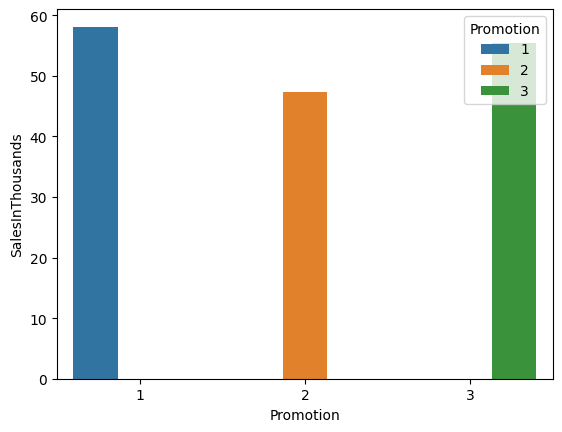

In [7]:
def vis_mean(df, xlabel, ylabel):
    mean_bar = sns.barplot(data=df, x=xlabel, y=ylabel, errorbar=None, hue=xlabel)
    
    promotion_mean_sales = df.groupby(xlabel)[ylabel].mean().reset_index(name='MeanSales')
    
    return mean_bar, promotion_mean_sales

vis_mean(df, 'Promotion', 'SalesInThousands')

#### iii. 귀무/대립 가설 수립

- 귀무가설(H0) : 프로모션 별로 매출의 분포는 다르지 않다.
- 대립가설(H1) : 프로모션 별로 매출의 분포는 다르다.

#### iv. Kruskal-Wallis 방법을 통한 가설 검정

In [8]:
def kruskal_wallis(df, t1, t2):
    # Promotion1, Promotion2, Promotion3 각각의 매출 데이터 추출
    gr_1 = df[df[t1] == 1][t2]
    gr_2 = df[df[t1] == 2][t2]
    gr_3 = df[df[t1] == 3][t2]

    # Kruskal-Wallis 검정
    result = kruskal(gr_1, gr_2, gr_3)

    # 결과 출력
    rounded_statistic = round(result.statistic, 4)
    rounded_pvalue = round(result.pvalue, 8)

    formatted_result = f"Kruskal-Wallis Test - Statistic: {rounded_statistic}, p-value: {rounded_pvalue}"

    print(formatted_result)

kruskal_wallis(df, 'Promotion', 'SalesInThousands')

Kruskal-Wallis Test - Statistic: 53.2948, p-value: 0.0


#### v. 결과 해석
- Statistic(Kruskal-Wallis 통계량) : 53.2948

    - 각 프로모션 그룹 간의 매출 순위 합의 차이를 나타내며, 값이 클수록 그룹 간의 차이가 크다는 것을 의미
    
- p-value : 0.0

    - 작은 p-value($\leq$0.05)는 귀무가설이 지지되지 않음을 의미, 따라서 귀무가설을 기각할 수 있는 근거가 됨

#### vi. 결론

이 결과로 인해 프로모션에 따른 매출의 차이가 통계적으로 유의미하게 나타남. 

> 대립가설(H1)인 '프로모션 별로 매출의 분포는 다르다.' 를 채택

### 가설 1-1. 1번 프로모션이 다른 두 프로모션에 비해 효과적일 것이다.
- 프로모션 별로 매출의 분포는 다르다는 것이 증명됐기 때문에 이 결과를 바탕으로
> '특정 프로모션이 다른 두 프로모션에 비해 효과적이다.' 라는 가설을 세울 수 있었음

#### i. 귀무/대립 가설 수립

- 귀무가설(H0) : 1번 프로모션이 다른 두 프로모션에 비해 효과적이지 않다.
- 대립가설(H1) : 1번 프로모션이 다른 두 프로모션에 비해 효과적이다.

#### ii. 사후분석(Dunn's Test) 방법을 통한 가설 검정

In [9]:
def hoc_dunn(df, t1, t2):
    # Dunn's Test
    dunn_result = sp.posthoc_dunn(df, val_col=t1, group_col=t2)

    # p-value를 반올림
    rounded_result = dunn_result.round(5)

    return rounded_result

hoc_dunn(df, 'SalesInThousands', 'Promotion')

,1,2,3
1,1.00000,0.0,0.04862
2,0.00000,1.0,0.00000
3,0.04862,0.0,1.00000


#### iii. 결과 해석

- 1번 프로모션 vs. 2번 프로모션

    - p-value가 0.05보다 작으므로 통계적으로 유의미한 차이가 있음
    - 1번 프로모션과 2번 프로모션 간의 매출은 유의미하게 다름

- 1번 프로모션 vs. 3번 프로모션

    - p-value가 0.05보다 작으므로 통계적으로 유의미한 차이가 있음
    - 1번 프로모션과 3번 프로모션 간의 매출은 유의미하게 다름
    - p-value가 유의 수준인 0.05를 겨우 넘김

- 2번 프로모션 vs. 3번 프로모션

    - p-value가 0.05보다 작으므로 통계적으로 유의미한 차이가 있음
    - 2번 프로모션과 3번 프로모션 간의 매출은 유의미하게 다름

#### iv. 결론
대립가설(H1)을 채택
> '1번 프로모션이 다른 두 프로모션에 비해 효과적이다.'

### 가설 2. 특정 주차에 특정 프로모션을 진행하는 것이 전략적으로 높은 성과를 가져올 것이다.

#### i. 정규성 검증

Shapiro-Wilk 검정 결과 (p-value)
week 1, Promotion 1 : 0.00027
week 1, Promotion 2 : 0.00003
week 1, Promotion 3 : 0.00027
week 2, Promotion 1 : 0.00234
week 2, Promotion 2 : 0.00305
week 2, Promotion 3 : 0.02580
week 3, Promotion 1 : 0.00484
week 3, Promotion 2 : 0.00095
week 3, Promotion 3 : 0.00109
week 4, Promotion 1 : 0.00918
week 4, Promotion 2 : 0.00962
week 4, Promotion 3 : 0.00129


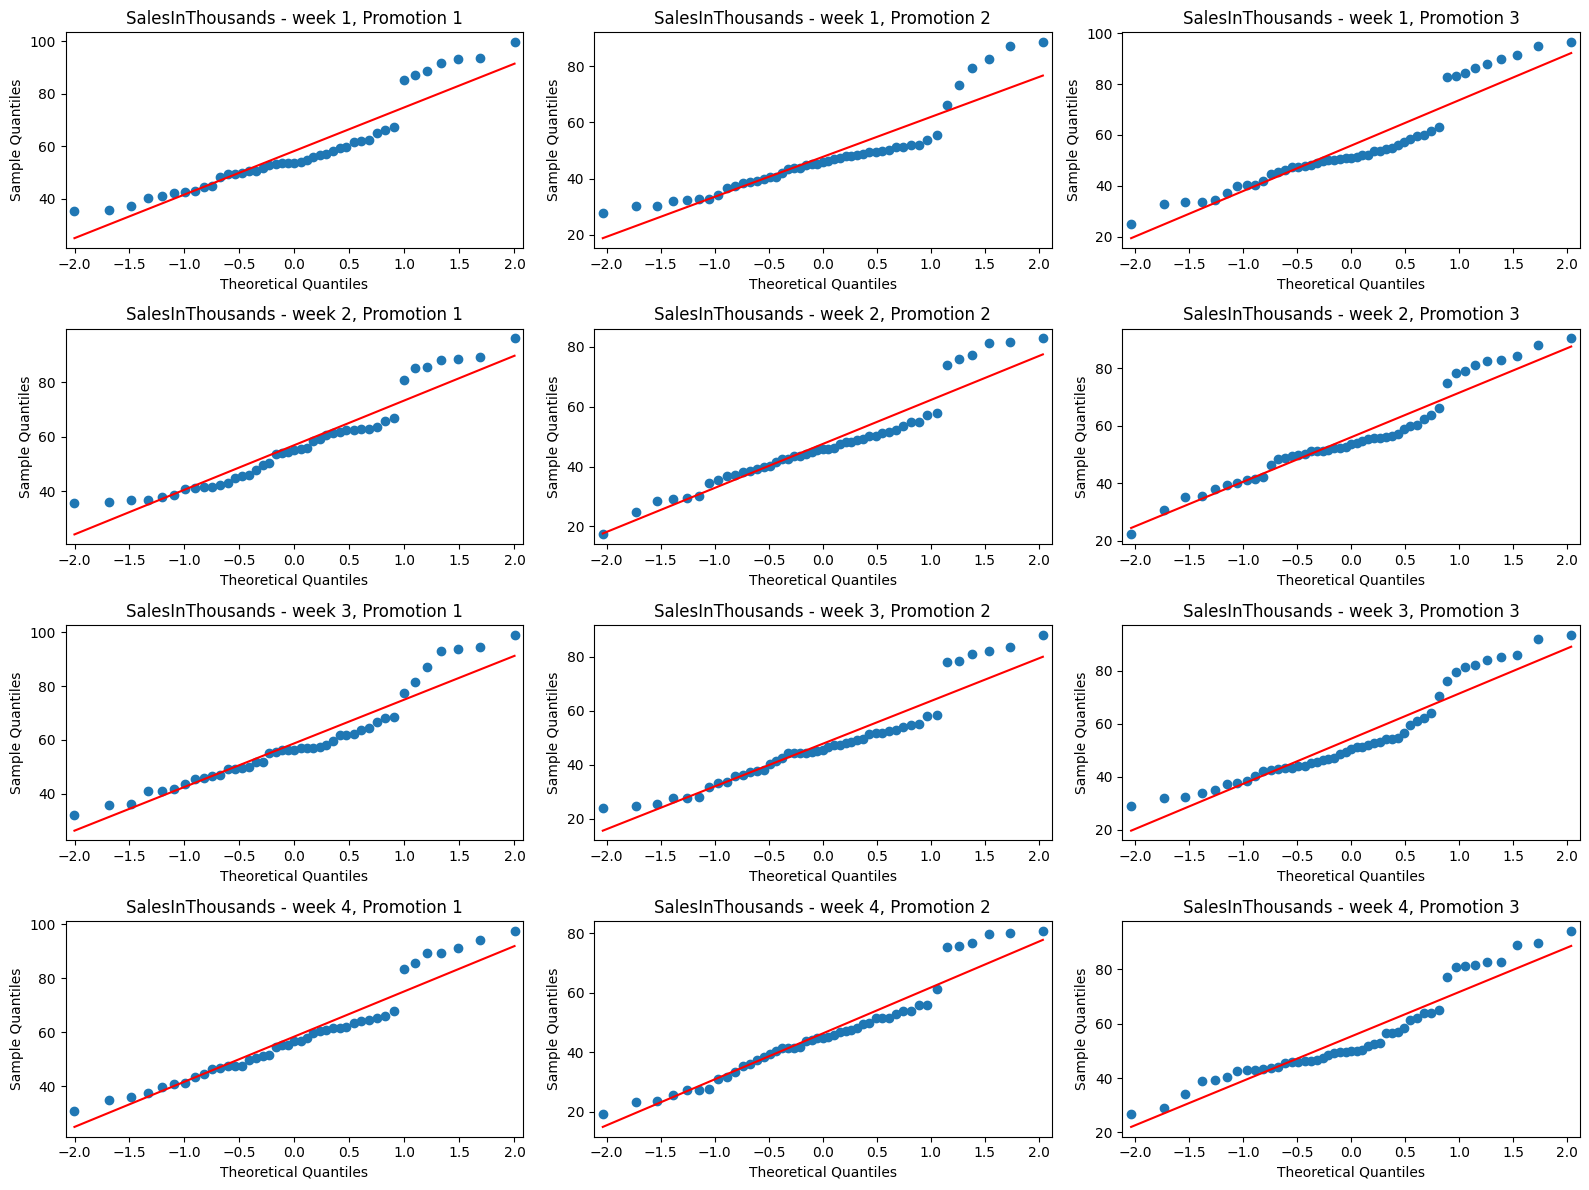

In [10]:
def is_normal_week(df, group_cols, ylabel):
    unique_groups = df.groupby(group_cols)

    rows = 4
    cols = 3
    f, ax = plt.subplots(rows, cols, figsize=(16, 12))
    print('Shapiro-Wilk 검정 결과 (p-value)')
    for i, (group_values, group_df) in enumerate(unique_groups):
        row = i // cols
        col = i % cols
        qqplot(np.array(group_df[ylabel]), line='s', ax=ax[row, col])
        ax[row, col].set_title(f'{ylabel} - {", ".join([f"{col} {val}" for col, val in zip(group_cols, group_values)])}')

        _, p_value = shapiro(np.array(group_df[ylabel]))
        print(f'{", ".join([f"{col} {val}" for col, val in zip(group_cols, group_values)])} : {p_value:.5f}')

    for i in range(len(unique_groups), rows * cols):
        row = i // cols
        col = i % cols
        ax[row, col].axis('off')

    plt.tight_layout()
    plt.show()

is_normal_week(df, ['week', 'Promotion'], 'SalesInThousands')

#### ii. 기반 데이터 시각화

(<Axes: xlabel='week', ylabel='SalesInThousands'>,
     Promotion  week  MeanSales
 0           1     1  58.244419
 1           1     2  56.929535
 2           1     3  58.774884
 3           1     4  58.447209
 4           2     1  47.730213
 5           2     2  47.582553
 6           2     3  47.722128
 7           2     4  46.282766
 8           3     1  55.776170
 9           3     2  55.949149
 10          3     3  54.377872
 11          3     4  55.354681)

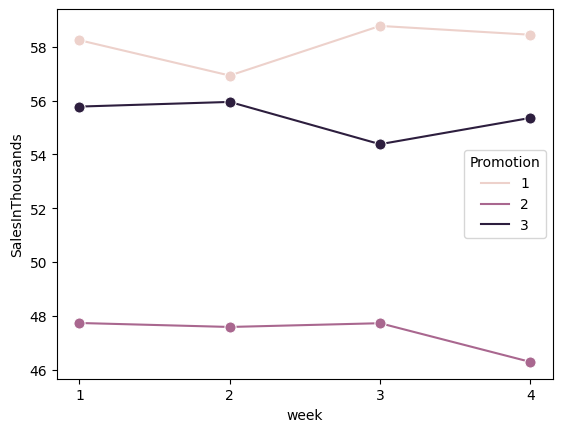

In [11]:
def vis_line_week(df, xlabel, ylabel):
    line_week = sns.lineplot(data=df, x='week', y=ylabel, hue=xlabel, errorbar=None, marker='o', markersize=8)
    plt.xticks(df['week'].unique())

    promotion_week_mean_sales = df.groupby([xlabel,'week'])[ylabel].mean().reset_index(name='MeanSales')
    
    return line_week, promotion_week_mean_sales

vis_line_week(df, 'Promotion', 'SalesInThousands')

#### iii. 귀무/대립 가설 수립 

- 귀무가설(H0) : 특정 주차에 특정 프로모션을 진행하는 것이 전략적으로 높은 성과가 없다.
- 대립가설(H1) : 특정 주차에 특정 프로모션을 진행하는 것이 전략적으로 높은 성과가 있다.

#### iv. Kruskal-Wallis 방법을 통한 가설 검정

In [12]:
def kruskal_2(df, var1, var2, var3):
    # Kruskal-Wallis Test 실행
    result = kruskal(*[group[var1] for name, group in df.groupby([var2, var3])])
    
    # 결과 출력
    rounded_statistic = round(result.statistic, 3)
    rounded_pvalue = round(result.pvalue, 3)
    
    formatted_result = f"Kruskal-Wallis Test - Statistic: {rounded_statistic}, p-value: {rounded_pvalue}"
    
    print(formatted_result)

kruskal_2(df, 'SalesInThousands', 'Promotion', 'week')

Kruskal-Wallis Test - Statistic: 55.203, p-value: 0.0


#### v. 결과 해석

- Statistic(Kruskal-Wallis 통계량) : 55.203
    - Kruskal-Wallis 통계량은 그룹 간의 순위 합을 비교한 값으로, 이 값이 크면 그룹 간에 중앙값이 다르다는 것을 나타냄
    
- p-value: 0.0
    - p-value가 0.0이라는 것은 귀무가설을 기각할 충분한 증거가 있다는 것을 나타냄
    - 적어도 하나의 주차 또는 프로모션 간에 매출의 중위수가 차이가 있다고 할 수 있음

#### vi. 결론

귀무가설(H0)을 기각할 근거가 충분하다고 할 수 있음 따라서 대립가설(H1)을 채택

> '특정 주차에 특정 프로모션을 진행하는 것이 전략적으로 높은 성과가 있다.'

### 가설 2-1. 2주차 매출에 대해 1번 프로모션이 2번 프로모션보다 효과적이라고 할 수 있을 것이다.

#### i. 귀무/대립 가설 수립 

- 귀무가설(H0) : 2주차 매출에 대해 1번 프로모션이 2번 프로모션보다 효과적이지 않다.
- 대립가설(H1) : 2주차 매출에 대해 1번 프로모션이 2번 프로모션보다 효과적이다.

#### ii. 사후분석(Dunn's Test) 방법을 통한 가설 검정

In [13]:
def dunn_test(df, v1, v2, v3):
    # 2주차 매출에 대한 데이터 추출
    data_2nd_week = df[df[v3] == 2]
    
    # Dunn's Test 실행
    result = sp.posthoc_dunn([data_2nd_week[data_2nd_week[v1] == 1][v2],
                              data_2nd_week[data_2nd_week[v1] == 2][v2]],
                             p_adjust='bonferroni')
    
    return result

dunn_test(df, 'Promotion', 'SalesInThousands', 'week')

,1,2
1,1.000000,0.004938
2,0.004938,1.000000


#### iii. 결과 해석 
- p-value : 0.004938
    - p-value 값이 0.05보다 작게 나타남에 따라 귀무가설 기각

#### iv. 결론 
귀무가설(H0)을 기각하고 대립가설(H1)을 채택
> '2주차 매출에 대해 1번 프로모션이 2번 프로모션보다 효과적이다.'

# 지역별 A/B Test

## 개요

1. MarketID별로 프로모션의 효과가 다를 것 이다.
    
2.  MarketID 전체적으로 프로모션 시작 후 매출이 증가하는 형태를 보일 것 이다. 

## 가설 검정


### 가설 1. MarketID별로 프로모션의 효과가 다를 것 이다.

#### i. 정규성 검증

In [14]:
# MarketID별로 그룹화된 데이터
data = df.groupby(['Promotion','MarketID'])['SalesInThousands'].agg(['mean']).reset_index()
statsdata = data[['Promotion','MarketID','mean']]

for promotion_value in range(1, 11):
    subset_data = statsdata[statsdata['MarketID'] == promotion_value]['mean']

    if len(subset_data) >= 3:
            # 정규성 검정
            shapiro_stat, shapiro_p_value = stats.shapiro(subset_data)
            print(f'MarketID {promotion_value}: Shapiro Statistic = {shapiro_stat}, p-value = {shapiro_p_value}')

            # 왜도 측정
            skewness_value = abs(stats.skew(subset_data, bias=False))
            print(f'MarketID {promotion_value}: Skewness = {skewness_value}')

            print()
    else:
        print(f'MarketID {promotion_value}: Not enough data for the test.')
        print()

MarketID 1: Shapiro Statistic = 0.9756298065185547, p-value = 0.7006282491514839
MarketID 1: Skewness = 0.7848097682643634

MarketID 2: Not enough data for the test.

MarketID 3: Shapiro Statistic = 0.9987981915473938, p-value = 0.9337774297152406
MarketID 3: Skewness = 0.1798427857302702

MarketID 4: Shapiro Statistic = 0.8688361644744873, p-value = 0.2922251563172896
MarketID 4: Skewness = 1.5527564688137212

MarketID 5: Shapiro Statistic = 0.9997849464416504, p-value = 0.9719914735099998
MarketID 5: Skewness = 0.07621279276865277

MarketID 6: Shapiro Statistic = 0.9996303915977478, p-value = 0.963280306103455
MarketID 6: Skewness = 0.09985482953561678

MarketID 7: Shapiro Statistic = 0.9962655305862427, p-value = 0.8832151487515079
MarketID 7: Skewness = 0.3159604112928105

MarketID 8: Shapiro Statistic = 0.8975098729133606, p-value = 0.3776186788090736
MarketID 8: Skewness = 1.4361778948701664

MarketID 9: Shapiro Statistic = 0.9419096112251282, p-value = 0.5351093806599723
MarketI

In [15]:
# MarketID별로 그룹화된 데이터
data = df.groupby(['Promotion','MarketID'])['SalesInThousands'].agg(['mean']).reset_index()
anovadata = data[['Promotion','MarketID','mean']]


# 이원분산분석 (Two-Way ANOVA) - 상호작용 항 제거
formula = 'mean ~ C(Promotion) + C(MarketID)'
model = ols(formula, data=anovadata).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# 결과 출력
anova_table

,sum_sq,df,F,PR(>F)
C(Promotion),407.625110,2.0,151.916421,1.430362e-11
C(MarketID),5204.400264,9.0,431.024512,2.954474e-18
Residual,22.807366,17.0,NaN,NaN


#### ii. 기반 데이터 시각화

In [16]:
#원본 데이터 복사
data_LocationIDcategory = df.copy()

#MarketID(시장 고유 식별자)별 SalesInThousands(매출)통계 확인
data = data_LocationIDcategory.groupby(
    ['Promotion','MarketID'])['SalesInThousands'].agg(['sum','count','mean','std','median']).reset_index()
data

,Promotion,MarketID,sum,count,mean,std,median
0,1,1,814.38,20,40.719000,4.970454,39.770
1,1,2,262.40,4,65.600000,3.331496,66.525
2,1,3,2510.12,28,89.647143,5.538530,89.285
3,1,4,940.85,16,58.803125,4.606967,58.370
4,1,5,444.13,8,55.516250,4.549590,55.195
5,1,6,813.30,20,40.665000,5.062069,41.100
6,1,7,801.94,16,50.121250,5.363200,49.350
7,1,8,1022.80,20,51.140000,5.757666,51.365
8,1,9,680.02,12,56.668333,4.967688,57.570
9,1,10,1703.09,28,60.824643,5.273758,62.140


MarketID
3     88
10    80
5     60
6     60
7     60
1     52
8     48
9     40
4     36
2     24
Name: count, dtype: int64

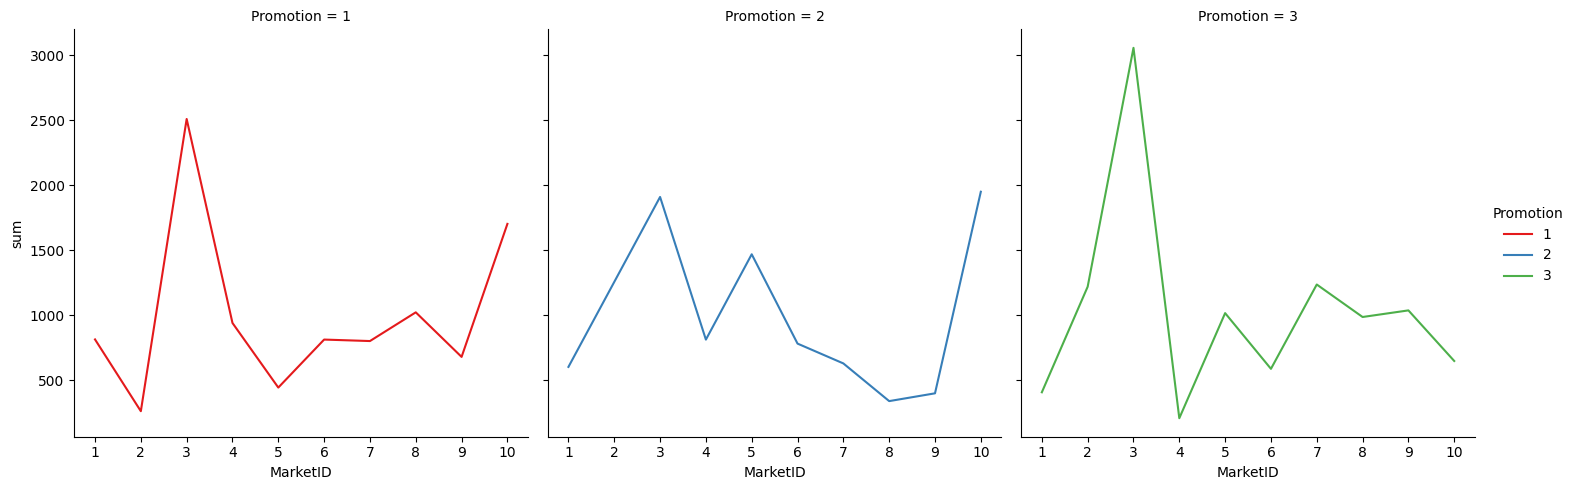

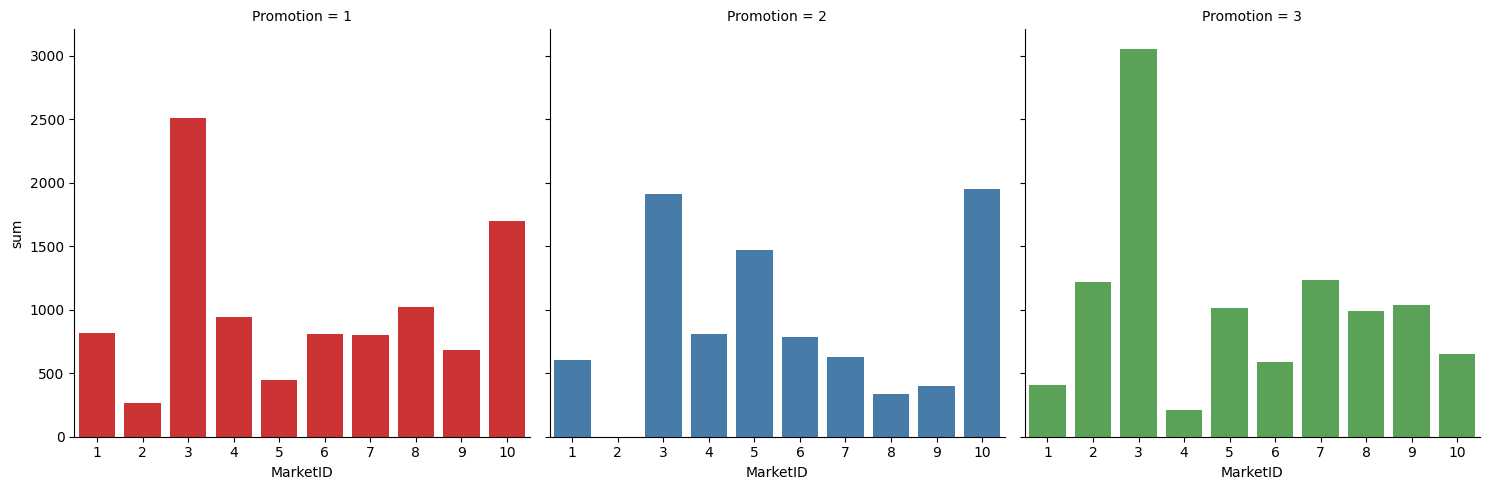

In [17]:
#시각화 1 : 상권별 프로모션에 대한 매출 합계
sns.relplot(
    data=data,x='MarketID',y='sum',hue='Promotion',col='Promotion',kind='line',palette='Set1'
    )
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.show

sns.catplot(
    data=data,x='MarketID',y='sum',hue='Promotion',col='Promotion',kind='bar',palette='Set1',dodge=False
    )
plt.show

#MarketID별 갯수
data.groupby('MarketID')['count'].sum().sort_values(ascending=False)

#### iii. 귀무/대립 가설 수립
- 귀무가설 (H0): 모든 MarketID에 대해 프로모션의 효과는 동일하다.
- 대립가설 (H1): MarketID별로 프로모션의 효과가 다를 것 이다.


#### iii. 가설 검정

<function matplotlib.pyplot.show(close=None, block=None)>

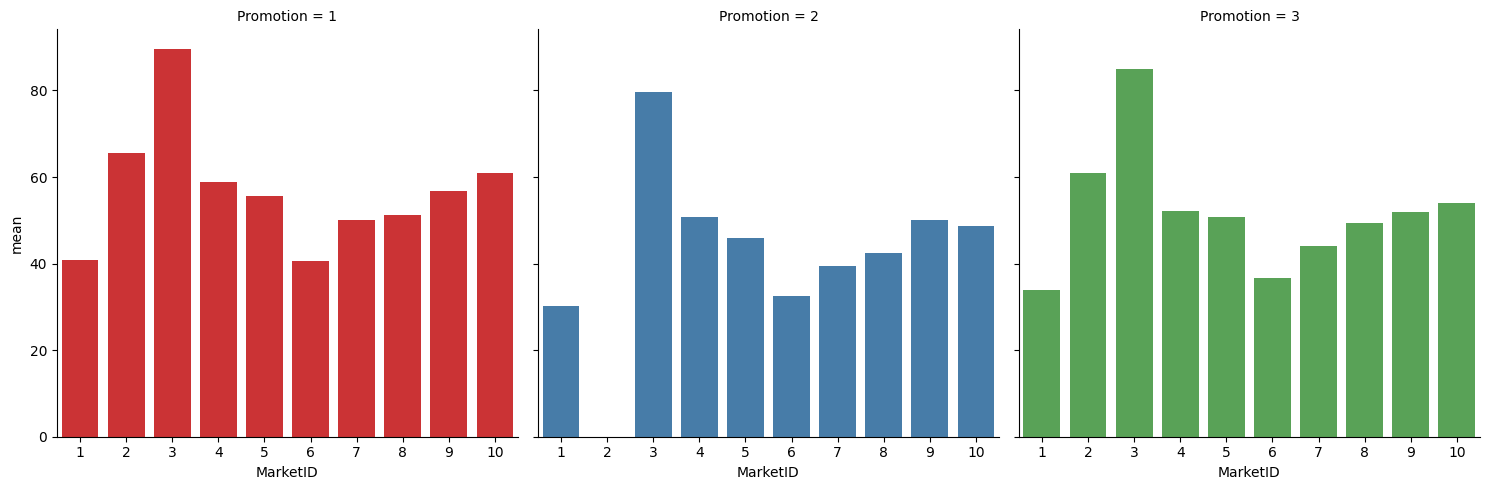

In [18]:
#시각화 2 : 상권별 프로모션에 대한 매출 평균

sns.catplot(
    data=data,x='MarketID',y='mean',hue='Promotion',col='Promotion',kind='bar',palette='Set1',dodge=False
    )
plt.show


In [19]:
#MarkeSize를 통한 매장 크기 확인
test_data = df[['MarketID','MarketSize','SalesInThousands']]
test_data.groupby(['MarketID','MarketSize']).mean('SalesInThousands').sort_values(['SalesInThousands','MarketSize'],ascending=False)

,,SalesInThousands
MarketID,MarketSize,
3,Large,84.971705
2,Small,61.761250
4,Small,54.508056
10,Large,53.776250
9,Medium,52.940750
8,Medium,48.952917
5,Medium,48.838000
7,Medium,44.475333
6,Medium,36.397500


<function matplotlib.pyplot.show(close=None, block=None)>

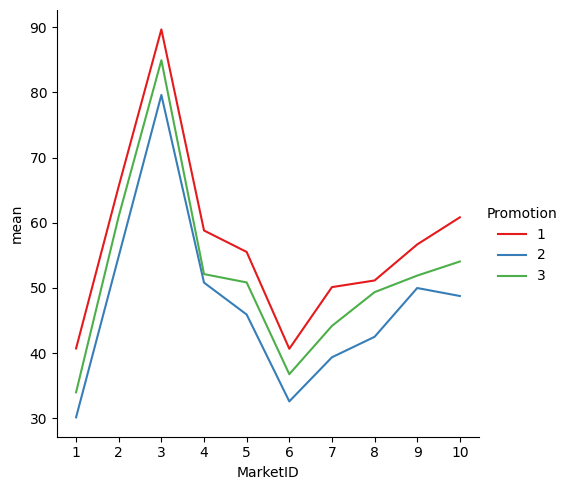

In [20]:
# MarketI에서 가장 좋은 효과를 보인 프로모션
sns.relplot(
    data=data,x='MarketID',y='mean',hue='Promotion',kind='line',palette='Set1'
    )
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.show

#### v.결과 해석 

1. Two-way ANOVA를 통해 'MarketID별로 프로모션의 효과가 다를 것 이다.'라는 가설은 채택가능한 것으로 확인되었습니다.

2. MarketID별 매장 수가 다르기 때문에 합계보다는 평균값을 통해 비교 분석 하는것이 의미있어 보입니다.

3. 1, 2, 3프로모션 모두 각 MarketID별로 SalesInThousands 평균값이 비슷한 모습으로 증감 하고있습니다.<br>
    특히 MarketID 3이 다른 MarketID보다 월등한 매출을 보입니다.
    * 이는 두가지로 해석할 수 있습니다.<br>
    1. MarketID별로 유동인구, 서비스 품질 등이 다르기 때문에 매출액이 다른 것이다.<br>
    2. MarketID별로 프로모션에 대한 효과가 다르기 때문에 매출액이 다른 것이다.
    * MarketSize와 함께 비교한 결과 MarketID별로 프로모션에 대한 효과가 다르기 때문에 매출액이 다른 것으로 볼 수 있었습니다.<br>
        특히 MarketID 2,4 의 경우 아주 좋은 성과를 보였습니다.

#### vi. 결론 

- 각 MarketID별로 SalesInThousands 평균값을 보아. 1번 프로모션이 모든 MarketID에서 가장 높게 측정되고 있습니다.
    * 프로모션 선택시 1번 프로모션이 가장 유리할 것으로 보입니다.

### 가설 2. 프로모션 시작 후 MarketID별로 매출이 증가하는 형태를 보일 것이다. 

#### ii. 기반 데이터 시각화

In [21]:
#원본데이터 복사
data_week = df.copy()

#MarketID별 주차에 따른 SalesInThousands(매출)통계 확인
data = data_week.groupby(['Promotion','MarketID','week'])['SalesInThousands'].agg(['sum','mean']).reset_index()
data

,Promotion,MarketID,week,sum,mean
0,1,1,1,211.20,42.240000
1,1,1,2,191.86,38.372000
2,1,1,3,215.52,43.104000
3,1,1,4,195.80,39.160000
4,1,2,1,67.48,67.480000
...,...,...,...,...,...
111,3,9,4,254.29,50.858000
112,3,10,1,159.73,53.243333
113,3,10,2,167.75,55.916667
114,3,10,3,162.55,54.183333


([<matplotlib.axis.XTick at 0x7f3745c6ef20>,
 [Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3'), Text(4, 0, '4')])

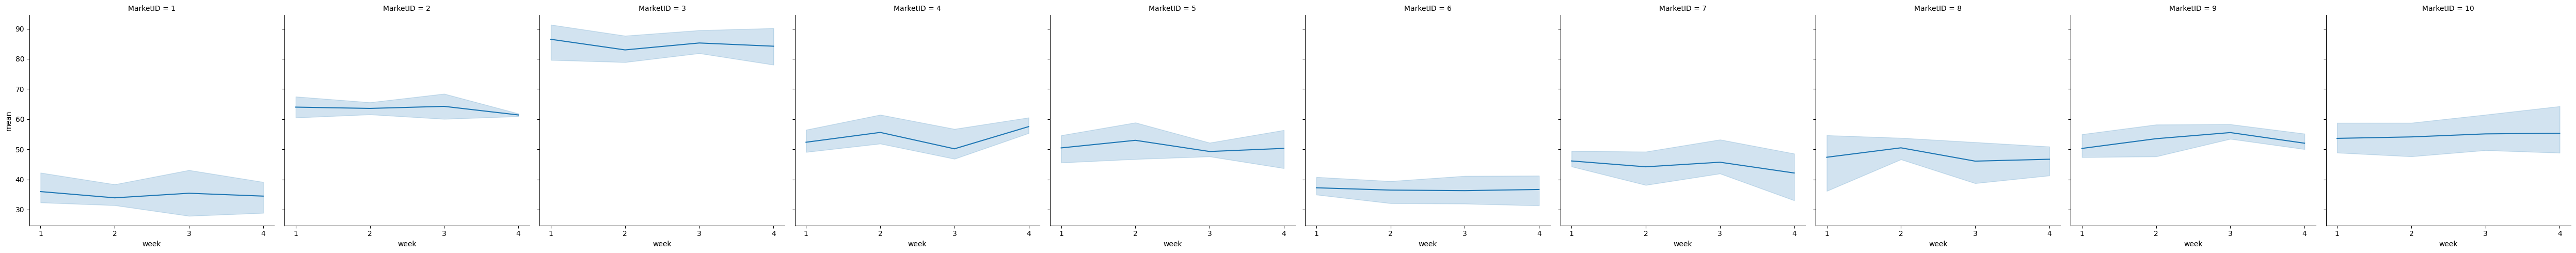

In [22]:
sns.relplot(data=data, x='week',y='mean',col='MarketID',kind='line')

plt.xticks([1,2,3,4])

#### iv. 가설검정 
- MarketID별로 프로모션 진행시 주차별로 매출에 대한 변화가 미비한 것으로 보입니다.

#### v. 결과 해석
- 프로모션을 진행하는 중에는 매출의 변화는 없으므로 아래와 같이 해석할 수 있겠습니다.

    - 프로모션을 시작했을 때 매출이 오른 뒤 유지되었다.
    - 프로모션을 시작했음에도 불구하고 매출의 변화가 없다.

프로모션 이전 데이터가 없으므로 둘 중 어떤 해석이 맞는지는 확인 할 수 없습니다.

# 운영기간별 A/B Test

## 개요

- 가설 1. AgeOfStores는 매출에 영향을 줄 것이다. 
- 가설 2. AgeOfStores의 값이 높을 수록 (운영기간이 길 수록) Promotion 1가 매출을 증가시키는데 효과적일 것이다. 


## 가설 검정

### 가설 1. AgeOfStores는 매출에 영향을 줄 것이다.

#### i. 정규성 검증

In [23]:
# Shapiro-Wilk test for AgeOfStores
stat_age, p_value_age = shapiro(df['AgeOfStore'])
print(f'Shapiro-Wilk test for AgeOfStores:\nStatistic: {stat_age}\nP-value: {p_value_age}')

# Shapiro-Wilk test for SalesInThousands
stat_sales, p_value_sales = shapiro(df['SalesInThousands'])
print(f'\nShapiro-Wilk test for SalesInThousands:\nStatistic: {stat_sales}\nP-value: {p_value_sales}')


Shapiro-Wilk test for AgeOfStores:
Statistic: 0.8913767337799072
P-value: 3.193154461892913e-19

Shapiro-Wilk test for SalesInThousands:
Statistic: 0.9346458911895752
P-value: 9.385896702592596e-15


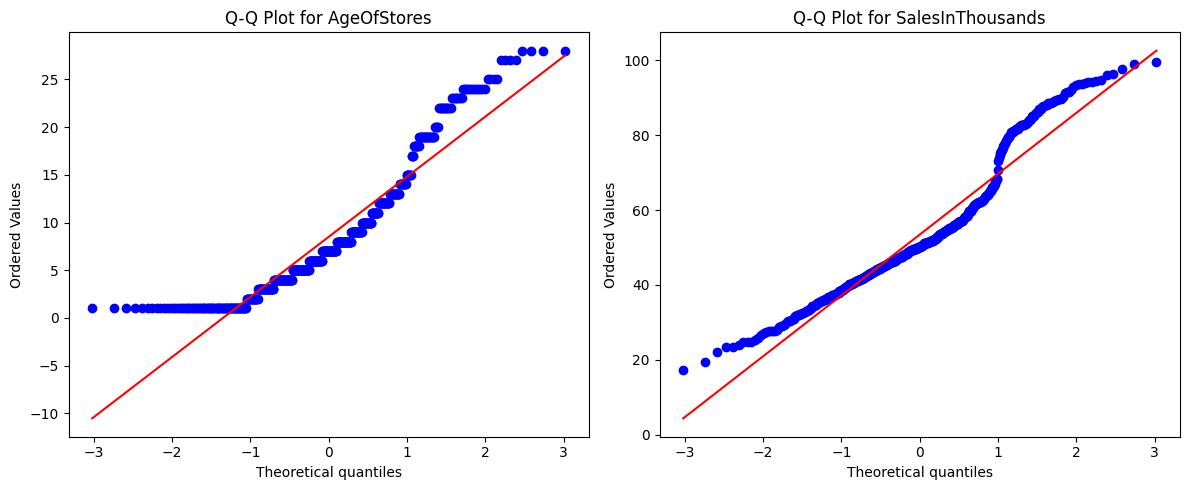

In [24]:
# AgeOfStores Q-Q plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
stats.probplot(df['AgeOfStore'], dist="norm", plot=plt)
plt.title('Q-Q Plot for AgeOfStores')

# SalesInThousands Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(df['SalesInThousands'], dist="norm", plot=plt)
plt.title('Q-Q Plot for SalesInThousands')

plt.tight_layout()
plt.show()

#### ii. 기반 데이터 시각화

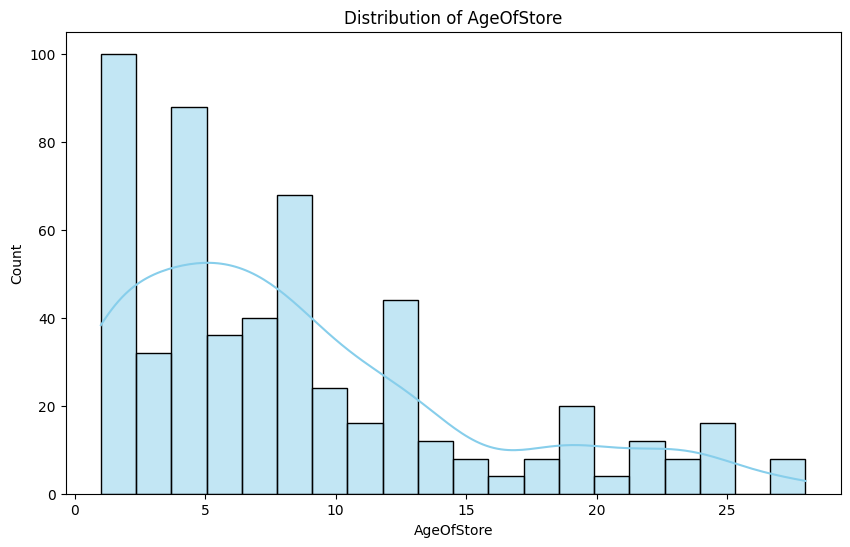

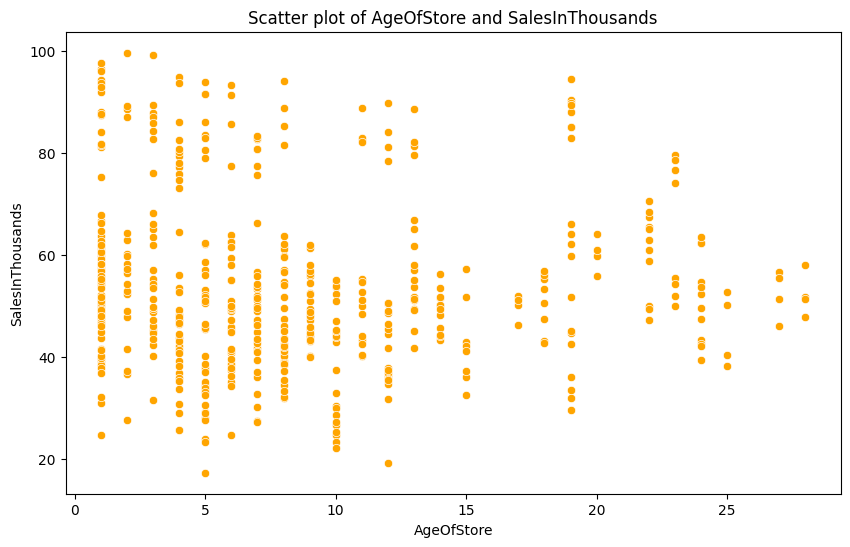

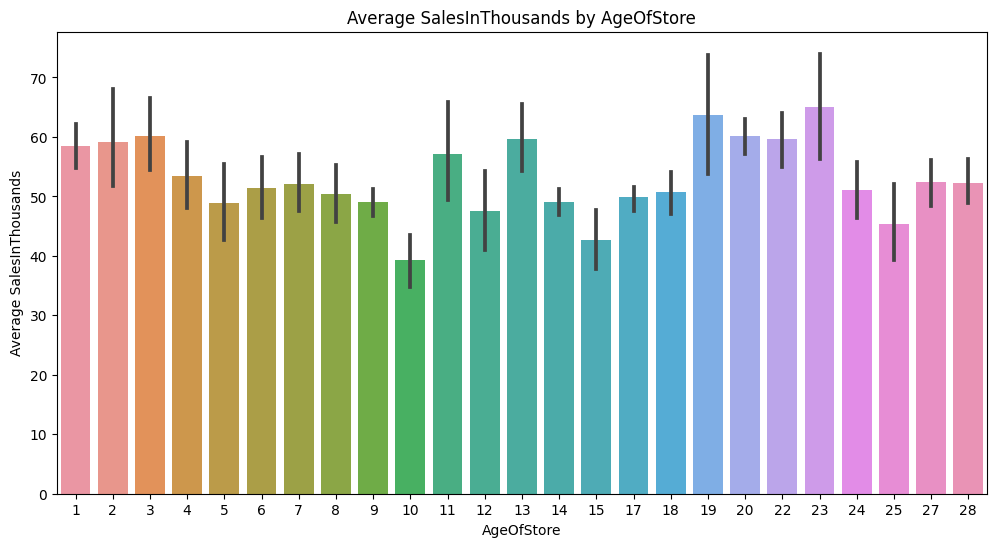

In [25]:
# AgeOfStore의 분포 확인
plt.figure(figsize=(10, 6))
sns.histplot(df['AgeOfStore'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of AgeOfStore')
plt.xlabel('AgeOfStore')
plt.show()

# AgeOfStore에 따른 SalesInThousands의 상관 관계 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AgeOfStore', y='SalesInThousands', data=df, color='orange')
plt.title('Scatter plot of AgeOfStore and SalesInThousands')
plt.xlabel('AgeOfStore')
plt.ylabel('SalesInThousands')
plt.show()

# AgeOfStore 별 SalesInThousands의 평균 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='AgeOfStore', y='SalesInThousands', data=df)
plt.title('Average SalesInThousands by AgeOfStore')
plt.xlabel('AgeOfStore')
plt.ylabel('Average SalesInThousands')
plt.show()

#### iii. 귀무/대립 가설 수립 
- 귀무가설(H0) : "AgeOfStores는 SalesInThousands에 영향을 주지 않는다."
- 대립가설(H1) : "AgeOfStores는 SalesInThousands에 영향을 준다."

#### iv. T-Test 방법을 통한 가설 검정 

In [26]:
from scipy.stats import ttest_ind

# AgeOfStores를 기준으로 그룹 나누기
high_age_group = df[df['AgeOfStore'] > df['AgeOfStore'].median()]['SalesInThousands']
low_age_group = df[df['AgeOfStore'] <= df['AgeOfStore'].median()]['SalesInThousands']

# A/B 테스트 (t-test)
t_statistic, p_value = ttest_ind(high_age_group, low_age_group, equal_var=False)

# 결과 출력
print(f'T-statistic: {t_statistic}\nP-value: {p_value}')

# 유의수준 0.05에서 검정
if p_value < 0.05:
    print("AgeOfStores는 SalesInThousands에 영향을 줄 것으로 나타났습니다. (귀무가설 기각)")
else:
    print("AgeOfStores는 SalesInThousands에 영향을 주지 않는 것으로 나타났습니다. (귀무가설 채택)")


T-statistic: -2.0424781492614428
P-value: 0.0415848140315863
AgeOfStores는 SalesInThousands에 영향을 줄 것으로 나타났습니다. (귀무가설 기각)


#### v. 결과 해석 

>“AgeOfStores는 SalesInThousands에 영향을 준다.”라는 대립가설 채택

#### vi. 결론 

앞선 검증 방법을 통해 얻은 결론은 “AgeOfStores는 SalesInThousands에 영향을 준다.”


### 가설 2. AgeOfStores의 값이 높을 수록 Promotion 1가 매출을 증가시키는데 교과적일 것이다. 

#### i. 정규성 검증

In [27]:
# Shapiro-Wilk test for AgeOfStores
stat_age, p_value_age = shapiro(df['AgeOfStore'])
print(f'Shapiro-Wilk test for AgeOfStores:\nStatistic: {stat_age}\nP-value: {p_value_age}')

# Shapiro-Wilk test for SalesInThousands
stat_sales, p_value_sales = shapiro(df['SalesInThousands'])
print(f'\nShapiro-Wilk test for SalesInThousands:\nStatistic: {stat_sales}\nP-value: {p_value_sales}')

# Shapiro-Wilk test for each Promotion group in AgeOfStore
for promotion_group in df['Promotion'].unique():
    data_promotion = df[df['Promotion'] == promotion_group]['AgeOfStore']
    stat_promotion, p_value_promotion = shapiro(data_promotion)
    print(f'\nShapiro-Wilk test for AgeOfStore in Promotion {promotion_group}:\nStatistic: {stat_promotion}\nP-value: {p_value_promotion}')

Shapiro-Wilk test for AgeOfStores:
Statistic: 0.8913767337799072
P-value: 3.193154461892913e-19

Shapiro-Wilk test for SalesInThousands:
Statistic: 0.9346458911895752
P-value: 9.385896702592596e-15

Shapiro-Wilk test for AgeOfStore in Promotion 3:
Statistic: 0.8827770352363586
P-value: 5.976826672471347e-11

Shapiro-Wilk test for AgeOfStore in Promotion 2:
Statistic: 0.8743744492530823
P-value: 2.0738393641250852e-11

Shapiro-Wilk test for AgeOfStore in Promotion 1:
Statistic: 0.8853486776351929
P-value: 3.121328473465468e-10


#### ii. 기반 데이터 시각화 

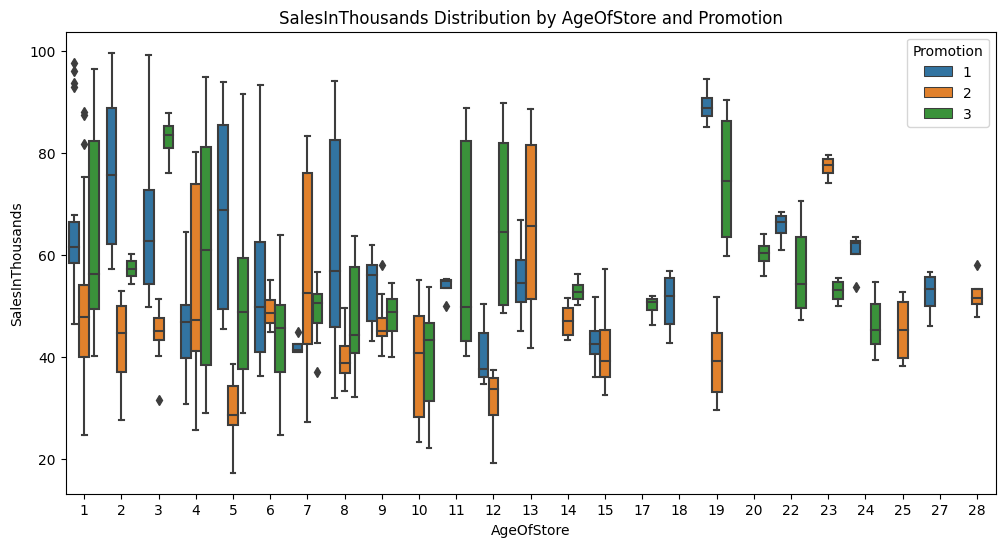

In [28]:
# AgeOfStore에 따른 Promotion에 대한 Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='AgeOfStore', y='SalesInThousands', hue='Promotion', data=df)
plt.title('SalesInThousands Distribution by AgeOfStore and Promotion')
plt.xlabel('AgeOfStore')
plt.ylabel('SalesInThousands')
plt.legend(title='Promotion', loc='upper right')
plt.show()

#### iii. 귀무/대립 가설 수립 
- 귀무가설(H0) : "AgeOfStores의 값과 Promotion 1간 매출의 유의미한 차이가 없다."
- 대립가설(H1) : "AgeOfStore의 값이 높을수록 Promotion 1이 매출을 증가시키는데 효과적이다."


#### iv. T-Test 방벙을 통한 가설 검정

In [29]:
# AgeOfStore를 기준으로 그룹 나누기
high_age_group_promotion_1 = df[(df['AgeOfStore'] > df['AgeOfStore'].median()) & (df['Promotion'] == 1)]['SalesInThousands']
low_age_group_promotion_1 = df[(df['AgeOfStore'] <= df['AgeOfStore'].median()) & (df['Promotion'] == 1)]['SalesInThousands']

# A/B 테스트 (t-test)
t_statistic, p_value = ttest_ind(high_age_group_promotion_1, low_age_group_promotion_1, equal_var=False)

# 결과 출력
print(f'T-statistic: {t_statistic}\nP-value: {p_value}')

# 유의수준 0.05에서 검정
if p_value < 0.05:
    print("AgeOfStore의 값이 높을수록 Promotion 1가 매출을 증가시키는데 효과적일 것으로 나타났습니다. (귀무가설 기각)")
else:
    print("AgeOfStore의 값이 높을수록 Promotion 1가 매출을 증가시키는데 효과적이지 않은 것으로 나타났습니다. (귀무가설 채택)")


T-statistic: -2.271790395527202
P-value: 0.024354031334866764
AgeOfStore의 값이 높을수록 Promotion 1가 매출을 증가시키는데 효과적일 것으로 나타났습니다. (귀무가설 기각)


#### v.결과 해석

>“AgeOfStores의 값과 Promotion 1간 매출의 유의미한 차이가 없다.” 귀무가설을 기각

#### vi. 결론

- 매장의 운영기간이 늘 수록 특정 프로모션이 매출에 영향을 주는데, 운영기간이 오래된 매장일 수록 1번 프로모션이 매출 증가에 영향을 미쳤음을 알 수 있음.


# 시장 크기별 A/B Test

## 개요 
1. 시장 크기가 작은 Small의 총 판매금액이 가장 낮을 것이다.
2. 시장 크기가 프로모션 선택에 미치는 영향

## 가설 검정

### 가설 1. Small이 총 판매금액이 가장 낮게 나왔을 것이다.

#### i. 정규성 검증

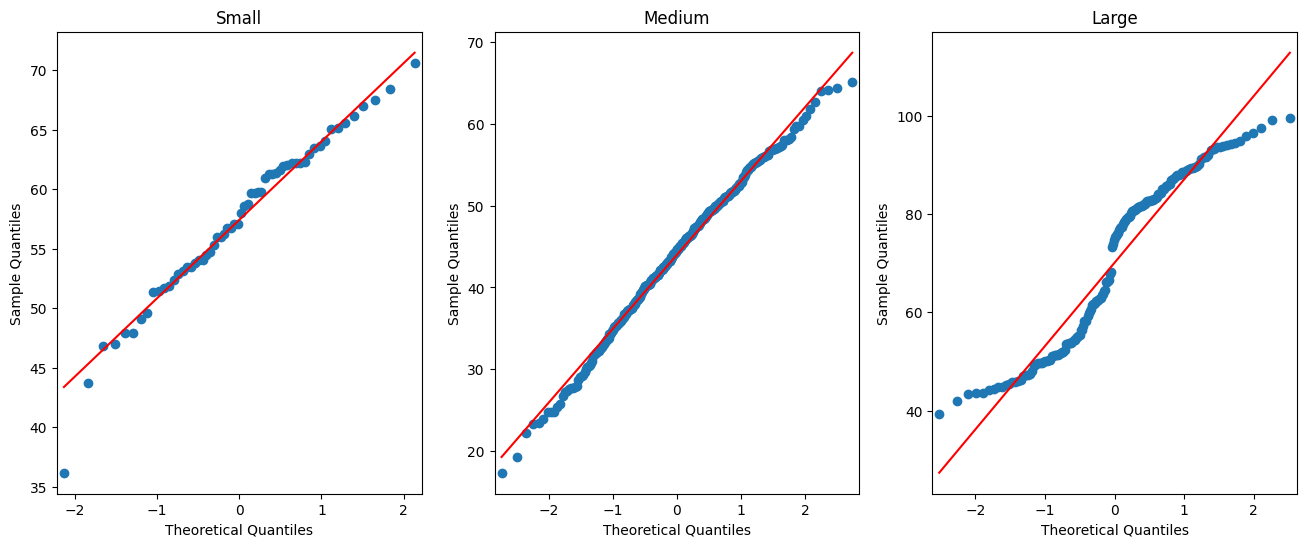

In [30]:
# Q-Q Plot
f, ax = plt.subplots(1,3,figsize=(16,6))

qqplot(np.array(df.loc[(df.MarketSize=='Small'), 'SalesInThousands']), line='s', ax=ax[0])
qqplot(np.array(df.loc[(df.MarketSize=='Medium'), 'SalesInThousands']), line='s', ax=ax[1])
qqplot(np.array(df.loc[(df.MarketSize=='Large'), 'SalesInThousands']), line='s', ax=ax[2])
ax[0].set_title("Small")
ax[1].set_title("Medium")
ax[2].set_title("Large")

plt.show()

In [31]:
marketSize = ['Small', 'Medium', 'Large']
for value in range(3):
    res = shapiro(df[df.MarketSize==marketSize[value]]['SalesInThousands'])
    print(f'MarketSize {marketSize[value]} p-value: {res}')

MarketSize Small p-value: ShapiroResult(statistic=0.9777514934539795, pvalue=0.3409940004348755)
MarketSize Medium p-value: ShapiroResult(statistic=0.9926648139953613, pvalue=0.11779474467039108)
MarketSize Large p-value: ShapiroResult(statistic=0.9209785461425781, pvalue=6.401694463420426e-08)


#### ii. 귀무/대립 가설 수립
- 귀무가설 : Small이 아닌 다른 시장의 총 판매금액이 가장 낮다.
- 대립가설 : Small의 총 판매금액이 가장 낮다.

#### iii. 가설 검증

In [32]:
# MarketID별로 그룹화된 데이터
data = df.groupby(['MarketSize','MarketID'])['LocationID'].agg(['count']).reset_index()
anovadata = data[['MarketSize','MarketID','count']]

# ANOVA 수행
result = [anovadata[anovadata['MarketSize'] == market]['count'] for market in anovadata['MarketSize'].unique()]
f_statistic, p_value = f_oneway(*result)

# 결과 출력
print("F-statistic:", f_statistic)
print("P-value:", p_value)

F-statistic: 23.171257485029905
P-value: 0.0008186267519324634


#### iv. 결과 해석

분석 결과로  p-value 값이 0.05 이하이므로 귀무가설이 기각되고 

> 대립가설인 ‘Small의 총 판매금액이 가장 낮다.’ 가 채택

In [33]:
# 시장사이즈별 판매 금액 합계
df_marketSize_sales_sum = df.groupby('MarketSize').agg({'SalesInThousands': 'sum'}).round().astype(int)
df_marketSize_sales_sum

,SalesInThousands
MarketSize,
Large,11780
Medium,14075
Small,3445


In [34]:
# 시장사이즈별 마켓 수 합계
df_marketSize_location_count = df.groupby('MarketSize').agg({'LocationID': 'count'})
df_marketSize_location_count4 = df_marketSize_location_count/4
df_marketSize_location_count4 = df_marketSize_location_count4.astype(int)
df_marketSize_location_count, df_marketSize_location_count4

(            LocationID
 MarketSize            
 Large              168
 Medium             320
 Small               60,
             LocationID
 MarketSize            
 Large               42
 Medium              80
 Small               15)

In [35]:
# 시장크기별 매출 평균
df_marketSize_mean = df_marketSize_sales_sum['SalesInThousands']/df_marketSize_location_count['LocationID']
df_marketSize_mean

MarketSize
Large     70.119048
Medium    43.984375
Small     57.416667
dtype: float64

In [36]:
# 데이터 순서 변경 large, medium, small -> small, medium, large
marketSize = ['Small', 'Medium', 'Large']
df_marketSize_sales_sum = df_marketSize_sales_sum.loc[marketSize]
df_marketSize_location_count = df_marketSize_location_count.loc[marketSize]
df_marketSize_location_count4 = df_marketSize_location_count4.loc[marketSize]
df_marketSize_sales_sum, df_marketSize_location_count, df_marketSize_location_count4

(            SalesInThousands
 MarketSize                  
 Small                   3445
 Medium                 14075
 Large                  11780,
             LocationID
 MarketSize            
 Small               60
 Medium             320
 Large              168,
             LocationID
 MarketSize            
 Small               15
 Medium              80
 Large               42)

Text(0.5, 0, 'MarketSize')

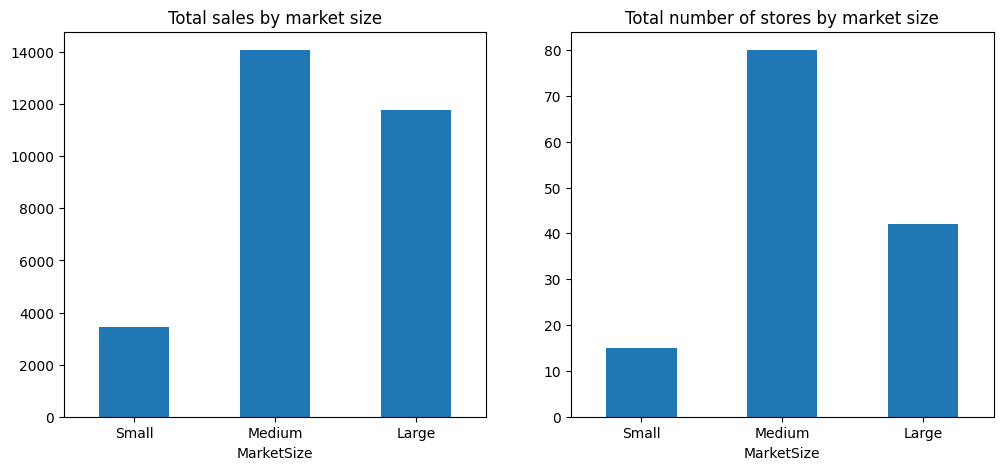

In [37]:
# subplot 그래프 나란히 보기
fig, axes = plt.subplots(1, 2, figsize=(12,5))


df_marketSize_sales_sum.plot(kind='bar',  ax=axes[0], legend=False)
axes[0].set_title('Total sales by market size')
axes[0].set_xticklabels(['Small', 'Medium', 'Large'], rotation=360)
# axes[0].bar_label(axes[0,0].containers[0])

df_marketSize_location_count4.plot(kind='bar', ax=axes[1], legend=False)
axes[1].set_title('Total number of stores by market size')
axes[1].set_xticklabels(['Small', 'Medium', 'Large'], rotation=360)
axes[1].set_xlabel('MarketSize') # x축 레이블 추가

#### v. 결론

- 시장 크기가 작다고 무조건 총 판매금액이 낮은 건 아니지만 결과적으로 Small의 총 판매금액이 가장 낮았고, 시장 크기가 작기 때문에 입점한 매장의 수가 적어서 총 판매금액이 낮았던 것을 그래프로 확인 가능

### 가설 2. 시장 크기가 프로모션 선택에 미티는 영향 시각화

#### i. 기반 데이터 분석 및 시각화

In [38]:
# 각 프로모션 선택 매장 개수
df_promotion_count = df.groupby('Promotion').agg({'LocationID' : 'count'})/4
df_promotion_count

,LocationID
Promotion,
1,43.0
2,47.0
3,47.0


In [39]:
# 매장 개수
df_marketSize_location_count4 = df_marketSize_location_count4.reset_index()
df_marketSize_location_count4

,MarketSize,LocationID
0,Small,15
1,Medium,80
2,Large,42


In [40]:
# 시장 크기별 매장 개수
small_count = df_marketSize_location_count4.loc[df_marketSize_location_count4['MarketSize'] == 'Small']
medium_count = df_marketSize_location_count4.loc[df_marketSize_location_count4['MarketSize'] == 'Medium']
large_count = df_marketSize_location_count4.loc[df_marketSize_location_count4['MarketSize'] == 'Large']
small_count, medium_count, large_count

(  MarketSize  LocationID
 0      Small          15,
   MarketSize  LocationID
 1     Medium          80,
   MarketSize  LocationID
 2      Large          42)

In [41]:
small_count = small_count['LocationID']
medium_count = medium_count['LocationID']
large_count = large_count['LocationID']
small_count, medium_count, large_count

(0    15
 Name: LocationID, dtype: int64,
 1    80
 Name: LocationID, dtype: int64,
 2    42
 Name: LocationID, dtype: int64)

In [42]:
tmp = df.groupby(['MarketSize', 'Promotion']).agg({'LocationID': 'count'})/4
tmp = tmp.reset_index()
tmp

,MarketSize,Promotion,LocationID
0,Large,1,14.0
1,Large,2,16.0
2,Large,3,12.0
3,Medium,1,24.0
4,Medium,2,27.0
5,Medium,3,29.0
6,Small,1,5.0
7,Small,2,4.0
8,Small,3,6.0


In [43]:
# 시장크기별 각 프로모션 선택 매장 수
small_tmp = tmp.loc[tmp['MarketSize'] == 'Small']
medium_tmp = tmp.loc[tmp['MarketSize'] == 'Medium']
large_tmp = tmp.loc[tmp['MarketSize'] == 'Large']
small_tmp = small_tmp['LocationID']
medium_tmp = medium_tmp['LocationID']
large_tmp = large_tmp['LocationID']
small_tmp, medium_tmp, large_tmp

(6    5.0
 7    4.0
 8    6.0
 Name: LocationID, dtype: float64,
 3    24.0
 4    27.0
 5    29.0
 Name: LocationID, dtype: float64,
 0    14.0
 1    16.0
 2    12.0
 Name: LocationID, dtype: float64)

In [44]:
small_tmp.index = [1,2,3]
medium_tmp.index = [1,2,3]
large_tmp.index = [1,2,3]
small_tmp, medium_tmp, large_tmp

(1    5.0
 2    4.0
 3    6.0
 Name: LocationID, dtype: float64,
 1    24.0
 2    27.0
 3    29.0
 Name: LocationID, dtype: float64,
 1    14.0
 2    16.0
 3    12.0
 Name: LocationID, dtype: float64)

In [45]:
small_tmp = small_tmp.astype(int)
medium_tmp = medium_tmp.astype(int)
large_tmp = large_tmp.astype(int)
small_tmp, medium_tmp, large_tmp

(1    5
 2    4
 3    6
 Name: LocationID, dtype: int64,
 1    24
 2    27
 3    29
 Name: LocationID, dtype: int64,
 1    14
 2    16
 3    12
 Name: LocationID, dtype: int64)

In [46]:
# 선택 비율 계산
small_tmp_pct1 = small_tmp.loc[1]/small_count*100
small_tmp_pct2 = small_tmp.loc[2]/small_count*100
small_tmp_pct3 = small_tmp.loc[3]/small_count*100
small_tmp_pct1 = small_tmp_pct1.round()
small_tmp_pct2 = small_tmp_pct2.round()
small_tmp_pct3 = small_tmp_pct3.round()


medium_tmp_pct1 = medium_tmp.loc[1]/medium_count*100
medium_tmp_pct2 = medium_tmp.loc[2]/medium_count*100
medium_tmp_pct3 = medium_tmp.loc[3]/medium_count*100
medium_tmp_pct1 = medium_tmp_pct1.round()
medium_tmp_pct2 = medium_tmp_pct2.round()
medium_tmp_pct3 = medium_tmp_pct3.round()
medium_tmp_pct1, medium_tmp_pct2, medium_tmp_pct3

large_tmp_pct1 = large_tmp.loc[1]/large_count*100
large_tmp_pct2 = large_tmp.loc[2]/large_count*100
large_tmp_pct3 = large_tmp.loc[3]/large_count*100
large_tmp_pct1 = large_tmp_pct1.round()
large_tmp_pct2 = large_tmp_pct2.round()
large_tmp_pct3 = large_tmp_pct3.round()
small_tmp_pct1, small_tmp_pct2, small_tmp_pct3, medium_tmp_pct1, medium_tmp_pct2, medium_tmp_pct3, large_tmp_pct1, large_tmp_pct2, large_tmp_pct3

(0    33.0
 Name: LocationID, dtype: float64,
 0    27.0
 Name: LocationID, dtype: float64,
 0    40.0
 Name: LocationID, dtype: float64,
 1    30.0
 Name: LocationID, dtype: float64,
 1    34.0
 Name: LocationID, dtype: float64,
 1    36.0
 Name: LocationID, dtype: float64,
 2    33.0
 Name: LocationID, dtype: float64,
 2    38.0
 Name: LocationID, dtype: float64,
 2    29.0
 Name: LocationID, dtype: float64)

In [47]:
small_all = pd.concat([small_tmp_pct1, small_tmp_pct2, small_tmp_pct3])
small_all.index = [1,2,3]


medium_all = pd.concat([medium_tmp_pct1, medium_tmp_pct2, medium_tmp_pct3])
medium_all.index = [1,2,3]
medium_all

large_all = pd.concat([large_tmp_pct1, large_tmp_pct2, large_tmp_pct3])
large_all.index = [1,2,3]
small_all, medium_all, large_all

(1    33.0
 2    27.0
 3    40.0
 Name: LocationID, dtype: float64,
 1    30.0
 2    34.0
 3    36.0
 Name: LocationID, dtype: float64,
 1    33.0
 2    38.0
 3    29.0
 Name: LocationID, dtype: float64)

In [48]:
promotion_all = pd.concat([small_all, medium_all, large_all], axis=1)
promotion_all.columns = ['Small', 'Medium', 'Large']
promotion_all

,Small,Medium,Large
1,33.0,30.0,33.0
2,27.0,34.0,38.0
3,40.0,36.0,29.0


[Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3')]

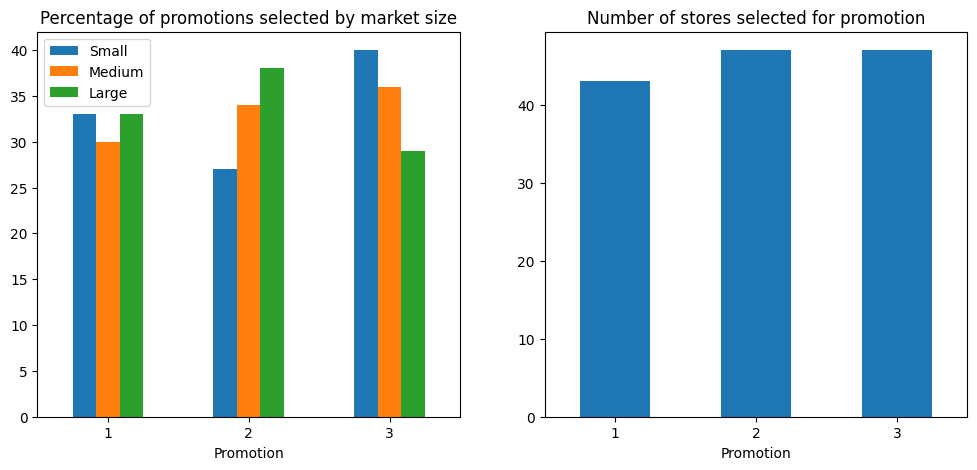

In [49]:
# subplot 그래프 나란히 보기
fig, axes = plt.subplots(1, 2, figsize=(12,5))


promotion_all.plot(kind='bar',  ax=axes[0], legend=False)
axes[0].set_title('Percentage of promotions selected by market size')
axes[0].set_xticklabels(['1', '2', '3'], rotation=360)
axes[0].set_xlabel('Promotion') # x축 레이블 추가
axes[0].legend(loc='upper left') # 범례 추가

df_promotion_count.plot(kind='bar', ax=axes[1], legend=False)
axes[1].set_title('Number of stores selected for promotion')
axes[1].set_xticklabels(['1', '2', '3'], rotation=360)

#### ii. 결론

1. **시장 크기가 가장 작은 Small의 총 판매금액이 가장 낮을 것**이라고 가설을 세웠는데 ANOVA 분석을 통해 귀무가설이 기각됐고 시각화를 통해서도 Small의 총 판매금액이 가장 낮음을 확인했다. 그래프를 통해서 Small 시장의 총 매장 수가 가장 적었기 때문에 총 판매금액이 낮았던 것도 확인 가능했다.

2. **시장 크기가 프로모션 션택에 미치는 영향**을 시각화로 알아봤다. 가장 많이 선택한 프로모션은 2,3번으로 2,3번 프로모션의 선택 매장 수가 같았는데 그 중에서도 2번 프로모션은 Small -> Medium -> Large 순으로 많이 선택했고, 3번 프로모션은 Large -> Medium -> Small 순으로 많이 선택한 것을 확인 할 수 있었다.